In [2]:
import pandas as pd
import numpy as np
import glob
import re
import time
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from scipy import sparse, stats

seed = 12345
np.random.seed(seed)

# Import Data

In [3]:
df_train = {}
df_test = {}

sub = pd.read_csv('C:/Users/user/Desktop/Pover-T Tests Predicting Poverty/submission_format.csv').drop('poor', axis = 1)

for file in glob.glob("C:/Users/user/Desktop/Pover-T Tests Predicting Poverty/train_data/*_train.csv"):
    label = file.split('\\')[1].split('_train')[0]
    
    if re.match(r'[A-C]_indiv', label):
        df_train[label] = pd.read_csv(file, index_col='id').drop(['country', 'iid'], 1)
    else:
        df_train[label] = pd.read_csv(file, index_col='id').drop(['country'], 1)
    
for file in glob.glob("C:/Users/user/Desktop/Pover-T Tests Predicting Poverty/test_data/*_test.csv"):
    label = file.split('\\')[1].split('_test')[0]
    
    if re.match(r'[A-C]_indiv', label):
        df_test[label] = pd.read_csv(file, index_col='id').drop(['country', 'iid'], 1)
    else:
        df_test[label] = pd.read_csv(file, index_col='id').drop(['country'], 1)

In [4]:
# drop all the columns with missing values
for datadict in [df_train, df_test]:
    for label, df in datadict.items():
        df.dropna(axis = 1, how = 'any', inplace = True)

In [5]:
# find and label the value that is not contained in both training and test data
for label, df in df_train.items():
    for col in [i for i in set(df) if df[i].dtype == "object"]:
        if set(df[col]) != set(df_test[label][col]):
            diff = list(set(df[col]) ^ set(df_test[label][col]))
            df[col].replace(diff, np.NaN, inplace = True)
            df_test[label][col].replace(diff, np.NaN, inplace = True)

In [6]:
# print the columns of the training data which contain missing values
for label, df in df_train.items():
    print(df.columns[df.isnull().any()])

Index(['LjvKYNON', 'nSzbETYS', 'tHFrzjai', 'nKoaotpH', 'UjuNwfjv'], dtype='object')
Index(['HeUgMnzF', 'NAxEQZVi', 'qqVibbSA'], dtype='object')
Index(['euTESpHe', 'FlWJlXVX', 'UwTBTjzr', 'qJMRBMxu', 'HFgaiygl', 'pKbELQat',
       'OrCClDbO', 'RVwFIIQe', 'uHXkmVcG', 'mMDEItQt', 'DlEhEQvh', 'tkkjBJlG',
       'jueNqsUo', 'knRcLhxE', 'StTakdgB', 'ciizMHyv', 'cqclFkuK', 'IrgyDDcl',
       'yZSARGEo', 'kmXNWkcV', 'VMvwrYds', 'ChbSWYhO'],
      dtype='object')
Index(['GjxOmHgp', 'EfqFGRSF', 'IPBrAaYt', 'HZEsXrsF', 'UkXhNUcd', 'uyhBLPFL',
       'jkutpUMt', 'SlqMdbUr', 'jyLFRgZs', 'YwcPaCNf', 'RFLvRzHv', 'mlyFwTHy',
       'zXonuRgn', 'ZHOSEFIu', 'XZUEzGLM', 'OFkIQOzS', 'BqXRUQgi', 'gsofZtJJ',
       'HQPtUibh', 'RUTkmJrl', 'hnwVYJyV', 'dfchpzYE', 'lLoRmWKX', 'KyTRKtbW',
       'zuvYUDSL', 'ljaNZowA', 'JniMXoSr', 'NUefhhHz', 'yNHqwYaJ', 'nkxrhykC',
       'OhKTEjVy', 'FHoVOXib', 'OATvAQNG', 'teSzyTms', 'MhvfpnqH', 'qzOZZsuS',
       'LSpCPhcU', 'zhbhQewN', 'qxVAoxyX', 'sWADnjxA', 'XIHNcHXI', 

In [7]:
# print the columns of the test data which contain missing values
for label, df in df_test.items():
    print(df.columns[df.isnull().any()])

Index([], dtype='object')
Index(['zTLPJYTw', 'qqVibbSA', 'RXcLsVAQ'], dtype='object')
Index(['RzaXNcgd', 'ZehDbxxy', 'qNlGOBmo', 'WTsZXhAX', 'StTakdgB', 'izDpdZxF',
       'TDBNBDil', 'dsUYhgai'],
      dtype='object')
Index(['GjxOmHgp', 'jyZvBZlo', 'kgVoFHRj', 'cRQWeYKZ', 'wEtnhPQs', 'PwxicsdL',
       'XZUEzGLM', 'OFkIQOzS', 'BqXRUQgi', 'eKkwQtwX', 'fwRLKHlN', 'HQPtUibh',
       'hnwVYJyV', 'dfchpzYE', 'ljaNZowA', 'JniMXoSr', 'yNHqwYaJ', 'OhKTEjVy',
       'OATvAQNG', 'LSpCPhcU', 'qxVAoxyX', 'XIHNcHXI', 'aYGuxgyP', 'DWmTWcUm',
       'PxgyaWYq'],
      dtype='object')
Index(['DNnBfiSI', 'gZWEypOM', 'rcVCcnDz', 'Bknkgmhs', 'IrEVgBSw', 'enTUTSQi',
       'nuMtebks'],
      dtype='object')
Index(['WqmeSStq'], dtype='object')


In [8]:
# Use backfill and forwardfill to impute the individual data and most frequent value for the household data
for datadict in [df_train, df_test]:
    for label, df in datadict.items():
        for col in set(df) - set(['poor']) :
            if re.match(r'[A-C]_indiv', label):
                df[col].fillna(method = 'ffill', inplace = True)
                df[col].fillna(method = 'bfill', inplace = True)
            else:
                df[col].fillna(df[col].value_counts().index[0], inplace = True)

In [9]:
# No more missing values
for datadict in [df_train, df_test]:
    for label, df in datadict.items():
        print(df.isnull().any().sum())

0
0
0
0
0
0
0
0
0
0
0
0


In [10]:
# Standardize all interval attributes
for datadict in [df_train, df_test]:
    for key, df in datadict.items():
        for col in set(df):
            if df[col].dtype in ['int64', 'float64']:
                df[col] = stats.zscore(df[col])

In [11]:
for datadict in [df_train, df_test]:
    for key, value in datadict.items():
        print(key, value.shape)

A_hhold (8203, 344)
A_indiv (37560, 40)
B_hhold (3255, 432)
B_indiv (20252, 196)
C_hhold (6469, 163)
C_indiv (29913, 41)
A_hhold (4041, 343)
A_indiv (18535, 39)
B_hhold (1604, 431)
B_indiv (10066, 195)
C_hhold (3187, 162)
C_indiv (14701, 40)


In [12]:
le = LabelEncoder()

# dictionary used to store training data
trnd = {}
# dictionary used to store test data
tstd = {} 


# Group individual data by mean after creating dummy variables
for key, value in df_train.items():
    if re.match(r'[A-C]_indiv', key):
        value['poor'] = le.fit_transform(value['poor'])
        trnd[key] = pd.get_dummies(value).reset_index().groupby('id').mean()
    else:
        trnd[key] = pd.get_dummies(value)
        trnd[key]['poor'] = le.fit_transform(trnd[key]['poor'])
                

for key, value in df_test.items():
    if re.match(r'[A-C]_indiv', key):
        tstd[key] = pd.get_dummies(value).reset_index().groupby('id').mean()
    else:
        tstd[key] = pd.get_dummies(value)
        
del df_train, df_test
gc.collect()

10594

In [13]:
#Make sure that training data has one more column (poor) in each set and individual data has same observations as household data


print('training dataset: ')
for key, value in trnd.items():
    print(key, value.shape)

print('test dataset: ')
for key, value in tstd.items():
    print(key, value.shape)

training dataset: 
A_hhold (8203, 851)
A_indiv (8203, 269)
B_hhold (3255, 1401)
B_indiv (3255, 1447)
C_hhold (6469, 761)
C_indiv (6469, 300)
test dataset: 
A_hhold (4041, 850)
A_indiv (4041, 268)
B_hhold (1604, 1400)
B_indiv (1604, 1446)
C_hhold (3187, 760)
C_indiv (3187, 299)


In [14]:
# find duplicate columns
print(set(trnd['A_hhold']) & set(trnd['A_indiv']))
print(set(trnd['B_hhold']) & set(trnd['B_indiv']))
print(set(trnd['C_hhold']) & set(trnd['C_indiv']))

{'poor'}
{'wJthinfa', 'poor'}
{'poor'}


In [15]:
print(set(tstd['A_hhold']) & set(tstd['A_indiv']))
print(set(tstd['B_hhold']) & set(tstd['B_indiv']))
print(set(tstd['C_hhold']) & set(tstd['C_indiv']))

set()
{'wJthinfa'}
set()


In [16]:
# fix the problem
trnd['B_hhold']['WJthinfa'] = trnd['B_hhold']['wJthinfa']
trnd['B_hhold'].drop('wJthinfa', 1, inplace = True)

tstd['B_hhold']['WJthinfa'] = tstd['B_hhold']['wJthinfa']
tstd['B_hhold'].drop('wJthinfa', 1, inplace = True)

print(set(trnd['A_hhold']) & set(trnd['A_indiv']))
print(set(trnd['B_hhold']) & set(trnd['B_indiv']))
print(set(trnd['C_hhold']) & set(trnd['C_indiv']))

{'poor'}
{'poor'}
{'poor'}


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Modeling process for each country
- Feature selection of individual data using Boruta
- Combining individual data and household data
- 10-fold CV using LGBM
- Predict on test data

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Country A

### Feature selection

In [17]:
fs_A_y = trnd['A_indiv'].pop('poor')
fs_A_X = trnd['A_indiv'].values

In [18]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=4)

feat_selector = BorutaPy(rf, n_estimators = 30, verbose=2, random_state=seed)

feat_selector.fit(fs_A_X, fs_A_y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	268
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	268
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	268
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	268
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	268
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	268
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	268
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	38
Tentative: 	89
Rejected: 	141


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	38
Tentative: 	89
Rejected: 	141


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	38
Tentative: 	89
Rejected: 	141


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	38
Tentative: 	89
Rejected: 	141


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	44
Tentative: 	64
Rejected: 	160


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	44
Tentative: 	64
Rejected: 	160


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	44
Tentative: 	64
Rejected: 	160


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	44
Tentative: 	64
Rejected: 	160


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	46
Tentative: 	55
Rejected: 	167


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	46
Tentative: 	55
Rejected: 	167


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	46
Tentative: 	55
Rejected: 	167


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	46
Tentative: 	49
Rejected: 	173


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	46
Tentative: 	49
Rejected: 	173


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	46
Tentative: 	49
Rejected: 	173


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	47
Tentative: 	42
Rejected: 	179


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	47
Tentative: 	42
Rejected: 	179


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	47
Tentative: 	42
Rejected: 	179


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	47
Tentative: 	42
Rejected: 	179


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	47
Tentative: 	38
Rejected: 	183


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	47
Tentative: 	38
Rejected: 	183


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	47
Tentative: 	38
Rejected: 	183


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	47
Tentative: 	38
Rejected: 	183


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	47
Tentative: 	38
Rejected: 	183


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	47
Tentative: 	38
Rejected: 	183


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	48
Tentative: 	35
Rejected: 	185


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	48
Tentative: 	35
Rejected: 	185


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	50
Tentative: 	33
Rejected: 	185


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	50
Tentative: 	33
Rejected: 	185


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	50
Tentative: 	33
Rejected: 	185


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	51
Tentative: 	29
Rejected: 	188


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	51
Tentative: 	29
Rejected: 	188


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	51
Tentative: 	29
Rejected: 	188


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	51
Tentative: 	29
Rejected: 	188


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	51
Tentative: 	29
Rejected: 	188


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	51
Tentative: 	29
Rejected: 	188


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	52
Tentative: 	28
Rejected: 	188


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	52
Tentative: 	28
Rejected: 	188


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	52
Tentative: 	27
Rejected: 	189


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	52
Tentative: 	27
Rejected: 	189


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	52
Tentative: 	27
Rejected: 	189


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	52
Tentative: 	27
Rejected: 	189


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	52
Tentative: 	27
Rejected: 	189


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	52
Tentative: 	26
Rejected: 	190


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	52
Tentative: 	26
Rejected: 	190


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	52
Tentative: 	26
Rejected: 	190


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	52
Tentative: 	26
Rejected: 	190


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	53
Tentative: 	25
Rejected: 	190


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	53
Tentative: 	25
Rejected: 	190


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	53
Tentative: 	25
Rejected: 	190


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	53
Tentative: 	25
Rejected: 	190


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	53
Tentative: 	25
Rejected: 	190


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	53
Tentative: 	25
Rejected: 	190


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	53
Tentative: 	24
Rejected: 	191


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	53
Tentative: 	24
Rejected: 	191


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	53
Tentative: 	24
Rejected: 	191


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	53
Tentative: 	24
Rejected: 	191


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	53
Tentative: 	24
Rejected: 	191


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	53
Tentative: 	23
Rejected: 	192


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	53
Tentative: 	23
Rejected: 	192


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	53
Tentative: 	23
Rejected: 	192


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	53
Tentative: 	23
Rejected: 	192


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	53
Tentative: 	23
Rejected: 	192


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	54
Tentative: 	21
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	54
Tentative: 	21
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	54
Tentative: 	21
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	54
Tentative: 	21
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	54
Tentative: 	21
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	55
Tentative: 	20
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	55
Tentative: 	20
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	55
Tentative: 	20
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	55
Tentative: 	20
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	55
Tentative: 	20
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	55
Tentative: 	20
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	55
Tentative: 	20
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	55
Tentative: 	20
Rejected: 	193


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	55
Tentative: 	19
Rejected: 	194


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	55
Tentative: 	19
Rejected: 	194


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	55
Tentative: 	18
Rejected: 	195


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	55
Tentative: 	18
Rejected: 	195


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	55
Tentative: 	18
Rejected: 	195


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	55
Tentative: 	18
Rejected: 	195


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	55
Tentative: 	18
Rejected: 	195


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	55
Tentative: 	16
Rejected: 	197


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	55
Tentative: 	16
Rejected: 	197


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	55
Tentative: 	16
Rejected: 	197


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	55
Tentative: 	15
Rejected: 	198


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	55
Tentative: 	15
Rejected: 	198


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	55
Tentative: 	15
Rejected: 	198


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	55
Tentative: 	15
Rejected: 	198


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	55
Tentative: 	15
Rejected: 	198


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	55
Tentative: 	15
Rejected: 	198
Iteration: 	99 / 100
Confirmed: 	55
Tentative: 	15
Rejected: 	198


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	55
Tentative: 	10
Rejected: 	198


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x0000029B81430240>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators=30, perc=100,
     random_state=<mtrand.RandomState object at 0x0000029B81430240>,
     two_step=True, verbose=2)

### Combining individual data and household data

In [19]:
A = pd.concat((trnd["A_indiv"].loc[:, feat_selector.support_], trnd['A_hhold']), 1)

X_A = A.drop('poor', 1)

y_A = A.poor

test_A = pd.concat((tstd['A_indiv'], tstd['A_hhold']), 1)[X_A.columns]

In [20]:
print(X_A.shape, type(X_A))
print(test_A.shape, type(test_A))
print(y_A.shape, type(y_A))

(8203, 905) <class 'pandas.core.frame.DataFrame'>
(4041, 905) <class 'pandas.core.frame.DataFrame'>
(8203,) <class 'pandas.core.series.Series'>


# LGBM

In [23]:
print('start CV')
start = time.time()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

lgbm_A = []

best_round = []

for train, test in kfold.split(X_A.values, y_A.values):

    lgb_train = lgb.Dataset(X_A.values[train], y_A.values[train], free_raw_data=False)

    lgb_eval = lgb.Dataset(X_A.values[test], y_A.values[test], reference=lgb_train, free_raw_data=False)

    params = {'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric': 'binary_logloss',
              'num_leaves': 31,
              'max_bin' : 500,
              'feature_fraction': 0.9,
              'bagging_fraction': 0.8,
              'bagging_freq': 5,
              'verbose': 1,
              'lambda_l2' : 1,
              'lambda_l1' : 1,
              'is_unbalance' : False, 
              'learning_rate' : 0.015}

    lgbm = lgb.train(params=params, 
                      train_set=lgb_train, 
                      num_boost_round=2000, 
                      valid_sets=lgb_eval, 
                      verbose_eval = 0,
                      early_stopping_rounds = 200)

    best_round.append(lgbm.best_iteration)

    lgbm_A.append(lgbm.best_score['valid_0']['binary_logloss'])

print("Average log loss: {} stddev : {}".format(np.mean(lgbm_A), np.std(lgbm_A)))

print('finish cv! : {} seconds'.format(time.time() - start))

start CV
Average log loss: 0.27433463152927423 stddev : 0.019140474626791307
finish cv! : 92.53198647499084 seconds


In [24]:
# Train the whole data
original_A = lgb.Dataset(X_A, y_A, free_raw_data=False)

lgbm = lgb.train(train_set = original_A, num_boost_round=np.max(best_round), params = params)

In [25]:
sub_A = {'id' : test_A.index,
         'poor' : lgbm.predict(test_A)}

sub_A = pd.DataFrame(sub_A)

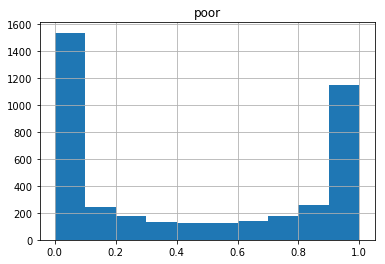

In [26]:
_ = sub_A.hist('poor')
plt.show()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Country B

### Feature selection

In [27]:
fs_B_y = trnd['B_indiv'].pop('poor')
fs_B_X = trnd['B_indiv'].values

In [28]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=4)

feat_selector = BorutaPy(rf, n_estimators = 30, verbose=2, random_state=seed)

feat_selector.fit(fs_B_X, fs_B_y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1446
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1446
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1446
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1446
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1446
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1446
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1446
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	152
Rejected: 	1294


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	152
Rejected: 	1294


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	152
Rejected: 	1294


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	152
Rejected: 	1294


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	103
Rejected: 	1343


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	103
Rejected: 	1343


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	103
Rejected: 	1343


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	103
Rejected: 	1343


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	1369


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	1369


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	1369


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	0
Tentative: 	65
Rejected: 	1381


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	0
Tentative: 	65
Rejected: 	1381


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	0
Tentative: 	65
Rejected: 	1381


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	3
Tentative: 	57
Rejected: 	1386


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	3
Tentative: 	57
Rejected: 	1386


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	3
Tentative: 	57
Rejected: 	1386


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	3
Tentative: 	57
Rejected: 	1386


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	3
Tentative: 	57
Rejected: 	1386


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	3
Tentative: 	56
Rejected: 	1387


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	3
Tentative: 	56
Rejected: 	1387


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	3
Tentative: 	55
Rejected: 	1388


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	3
Tentative: 	55
Rejected: 	1388


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	3
Tentative: 	55
Rejected: 	1388


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	4
Tentative: 	52
Rejected: 	1390


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	4
Tentative: 	52
Rejected: 	1390


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	4
Tentative: 	48
Rejected: 	1394


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	4
Tentative: 	48
Rejected: 	1394


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	4
Tentative: 	48
Rejected: 	1394


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	4
Tentative: 	47
Rejected: 	1395


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	4
Tentative: 	47
Rejected: 	1395


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	4
Tentative: 	47
Rejected: 	1395


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	4
Tentative: 	47
Rejected: 	1395


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	4
Tentative: 	47
Rejected: 	1395


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	4
Tentative: 	47
Rejected: 	1395


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	4
Tentative: 	46
Rejected: 	1396


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	4
Tentative: 	46
Rejected: 	1396


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	4
Tentative: 	46
Rejected: 	1396


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	5
Tentative: 	45
Rejected: 	1396


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	5
Tentative: 	45
Rejected: 	1396


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	5
Tentative: 	45
Rejected: 	1396


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	7
Tentative: 	42
Rejected: 	1397


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	7
Tentative: 	42
Rejected: 	1397


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	7
Tentative: 	42
Rejected: 	1397


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	7
Tentative: 	42
Rejected: 	1397


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	7
Tentative: 	42
Rejected: 	1397


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	7
Tentative: 	41
Rejected: 	1398


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	7
Tentative: 	41
Rejected: 	1398


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	7
Tentative: 	41
Rejected: 	1398


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	7
Tentative: 	41
Rejected: 	1398


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	7
Tentative: 	41
Rejected: 	1398


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	8
Tentative: 	40
Rejected: 	1398


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	8
Tentative: 	40
Rejected: 	1398


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	8
Tentative: 	40
Rejected: 	1398


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	8
Tentative: 	40
Rejected: 	1398


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	8
Tentative: 	40
Rejected: 	1398


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	8
Tentative: 	40
Rejected: 	1398


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	9
Tentative: 	38
Rejected: 	1399


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	9
Tentative: 	38
Rejected: 	1399


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	9
Tentative: 	35
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	10
Tentative: 	34
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	10
Tentative: 	34
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	10
Tentative: 	34
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	10
Tentative: 	34
Rejected: 	1402
Iteration: 	99 / 100
Confirmed: 	10
Tentative: 	34
Rejected: 	1402


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	10
Tentative: 	8
Rejected: 	1402


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x0000029BFA44C7E0>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators=30, perc=100,
     random_state=<mtrand.RandomState object at 0x0000029BFA44C7E0>,
     two_step=True, verbose=2)

### Combining individual data and household data

In [29]:
B = pd.concat((trnd["B_indiv"].loc[:, feat_selector.support_], trnd['B_hhold']), 1)

X_B = B.drop('poor', 1)

y_B = B.poor

test_B = pd.concat((tstd['B_indiv'], tstd['B_hhold']), 1)[X_B.columns]

In [30]:
print(X_B.shape, type(X_B))
print(test_B.shape, type(test_B))
print(y_B.shape, type(y_B))

(3255, 1410) <class 'pandas.core.frame.DataFrame'>
(1604, 1410) <class 'pandas.core.frame.DataFrame'>
(3255,) <class 'pandas.core.series.Series'>


# LGBM

In [31]:
print('start CV')
start = time.time()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

lgbm_B = []

best_round = []

for train, test in kfold.split(X_B.values, y_B.values):

    lgb_train = lgb.Dataset(X_B.values[train], y_B.values[train], free_raw_data=False)

    lgb_eval = lgb.Dataset(X_B.values[test], y_B.values[test], reference=lgb_train, free_raw_data=False)

    params = {'boosting_type': 'dart',
              'objective': 'binary',
              'metric': 'binary_logloss',
              'num_leaves': 31,
              'max_bin' : 500,
              'feature_fraction': 0.9,
              'bagging_fraction': 0.8,
              'bagging_freq': 5,
              'verbose': 1,
              'lambda_l2' : 1,
              'lambda_l1' : 1,
              'is_unbalance' : False, 
              'learning_rate' : 0.015}

    lgbm = lgb.train(params=params, 
                      train_set=lgb_train, 
                      num_boost_round=2000, 
                      valid_sets=lgb_eval, 
                      verbose_eval = 0,
                      early_stopping_rounds = 200)
    
    best_round.append(lgbm.best_iteration)

    lgbm_B.append(lgbm.best_score['valid_0']['binary_logloss'])

print("Average log loss: {} stddev : {}".format(np.mean(lgbm_B), np.std(lgbm_B)))

print('finish cv! : {} seconds'.format(time.time() - start))

start CV
Average log loss: 0.20897886773758048 stddev : 0.016922543817637678
finish cv! : 99.58914852142334 seconds


In [32]:
# Train the whole data
original_B = lgb.Dataset(X_B, y_B, free_raw_data=False)

lgbm = lgb.train(train_set = original_B, num_boost_round=np.max(best_round), params = params)

In [33]:
sub_B = {'id' : test_B.index,
         'poor' : lgbm.predict(test_B)}

sub_B = pd.DataFrame(sub_B)

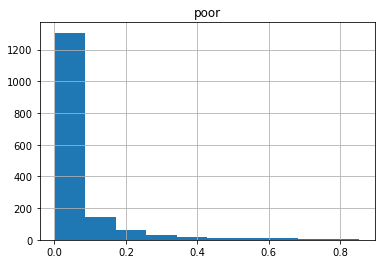

In [34]:
_ = sub_B.hist('poor')
plt.show()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++

# Country C

### Feature selection

In [35]:
fs_C_y = trnd['C_indiv'].pop('poor')
fs_C_X = trnd['C_indiv'].values

In [36]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=4)

feat_selector = BorutaPy(rf, n_estimators = 30, verbose=2, random_state=seed)

feat_selector.fit(fs_C_X, fs_C_y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	299
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	299
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	299
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	299
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	299
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	299
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	299
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	29
Tentative: 	75
Rejected: 	195


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	29
Tentative: 	75
Rejected: 	195


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	29
Tentative: 	75
Rejected: 	195


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	29
Tentative: 	75
Rejected: 	195


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	36
Tentative: 	58
Rejected: 	205


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	36
Tentative: 	58
Rejected: 	205


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	36
Tentative: 	58
Rejected: 	205


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	36
Tentative: 	58
Rejected: 	205


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	40
Tentative: 	48
Rejected: 	211


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	40
Tentative: 	48
Rejected: 	211


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	40
Tentative: 	48
Rejected: 	211


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	44
Tentative: 	39
Rejected: 	216


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	44
Tentative: 	39
Rejected: 	216


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	44
Tentative: 	39
Rejected: 	216


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	46
Tentative: 	37
Rejected: 	216


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	46
Tentative: 	37
Rejected: 	216


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	46
Tentative: 	37
Rejected: 	216


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	46
Tentative: 	36
Rejected: 	217


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	48
Tentative: 	34
Rejected: 	217


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	48
Tentative: 	34
Rejected: 	217


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	48
Tentative: 	34
Rejected: 	217


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	48
Tentative: 	34
Rejected: 	217


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	48
Tentative: 	34
Rejected: 	217


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	48
Tentative: 	33
Rejected: 	218


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	48
Tentative: 	33
Rejected: 	218


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	48
Tentative: 	33
Rejected: 	218


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	49
Tentative: 	32
Rejected: 	218


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	49
Tentative: 	32
Rejected: 	218


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	49
Tentative: 	32
Rejected: 	218


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	50
Tentative: 	31
Rejected: 	218


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	50
Tentative: 	31
Rejected: 	218


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	50
Tentative: 	30
Rejected: 	219


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	50
Tentative: 	30
Rejected: 	219


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	50
Tentative: 	30
Rejected: 	219


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	50
Tentative: 	30
Rejected: 	219


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	50
Tentative: 	28
Rejected: 	221


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	50
Tentative: 	28
Rejected: 	221


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	50
Tentative: 	28
Rejected: 	221


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	50
Tentative: 	28
Rejected: 	221


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	50
Tentative: 	28
Rejected: 	221


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	50
Tentative: 	28
Rejected: 	221


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	50
Tentative: 	25
Rejected: 	224


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	50
Tentative: 	25
Rejected: 	224


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	50
Tentative: 	23
Rejected: 	226


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	50
Tentative: 	23
Rejected: 	226


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	50
Tentative: 	23
Rejected: 	226


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	52
Tentative: 	21
Rejected: 	226


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	52
Tentative: 	21
Rejected: 	226


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	52
Tentative: 	21
Rejected: 	226


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	52
Tentative: 	21
Rejected: 	226


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	52
Tentative: 	21
Rejected: 	226


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	52
Tentative: 	21
Rejected: 	226


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	52
Tentative: 	20
Rejected: 	227


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	52
Tentative: 	20
Rejected: 	227


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	52
Tentative: 	20
Rejected: 	227


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	52
Tentative: 	20
Rejected: 	227


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	52
Tentative: 	20
Rejected: 	227


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	52
Tentative: 	20
Rejected: 	227


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	52
Tentative: 	20
Rejected: 	227


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	53
Tentative: 	19
Rejected: 	227


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	53
Tentative: 	19
Rejected: 	227


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	53
Tentative: 	19
Rejected: 	227


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	53
Tentative: 	18
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	53
Tentative: 	18
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	53
Tentative: 	18
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	53
Tentative: 	18
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	53
Tentative: 	18
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	53
Tentative: 	18
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	53
Tentative: 	18
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	54
Tentative: 	17
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	54
Tentative: 	17
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	54
Tentative: 	17
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	55
Tentative: 	16
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	55
Tentative: 	16
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	55
Tentative: 	16
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228
Iteration: 	99 / 100
Confirmed: 	56
Tentative: 	15
Rejected: 	228


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	56
Tentative: 	9
Rejected: 	228


C:\Users\user\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x0000029B8122F558>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators=30, perc=100,
     random_state=<mtrand.RandomState object at 0x0000029B8122F558>,
     two_step=True, verbose=2)

### Combining individual data and household data

In [37]:
C = pd.concat((trnd["C_indiv"].loc[:, feat_selector.support_], trnd['C_hhold']), 1)

X_C = C.drop('poor', 1)

y_C = C.poor

test_C = pd.concat((tstd['C_indiv'], tstd['C_hhold']), 1)[X_C.columns]

In [38]:
print(X_C.shape, type(X_C))
print(test_C.shape, type(test_C))
print(y_C.shape, type(y_C))

(6469, 816) <class 'pandas.core.frame.DataFrame'>
(3187, 816) <class 'pandas.core.frame.DataFrame'>
(6469,) <class 'pandas.core.series.Series'>


# LGCM

In [39]:
print('start CV')
start = time.time()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

lgbm_C = []

best_round = []

for train, test in kfold.split(X_C.values, y_C.values):

    lgb_train = lgb.Dataset(X_C.values[train], y_C.values[train], free_raw_data=False)

    lgb_eval = lgb.Dataset(X_C.values[test], y_C.values[test], reference=lgb_train, free_raw_data=False)

    params = {'boosting_type': 'dart',
              'objective': 'binary',
              'metric': 'binary_logloss',
              'num_leaves': 31,
              'max_bin' : 500,
              'feature_fraction': 0.9,
              'bagging_fraction': 0.8,
              'bagging_freq': 5,
              'verbose': 1,
              'lambda_l2' : 1,
              'lambda_l1' : 1,
              'is_unbalance' : False, 
              'learning_rate' : 0.015}

    lgbm = lgb.train(params=params, 
                      train_set=lgb_train, 
                      num_boost_round=2000, 
                      valid_sets=lgb_eval, 
                      verbose_eval = 0,
                      early_stopping_rounds = 200)
    
    best_round.append(lgbm.best_iteration)

    lgbm_C.append(lgbm.best_score['valid_0']['binary_logloss'])

print("Average log loss: {} stddev : {}".format(np.mean(lgbm_C), np.std(lgbm_C)))

print('finish cv! : {} seconds'.format(time.time() - start))

start CV
Average log loss: 0.018204726833898156 stddev : 0.008107329381193554
finish cv! : 97.60625290870667 seconds


In [40]:
# Train the whole data
original_C = lgb.Dataset(X_C, y_C, free_raw_data=False)

lgbm = lgb.train(train_set = original_C, num_boost_round=np.max(best_round), params = params)

In [41]:
sub_C = {'id' : test_C.index,
         'poor' : lgbm.predict(test_C)}

sub_C = pd.DataFrame(sub_C)

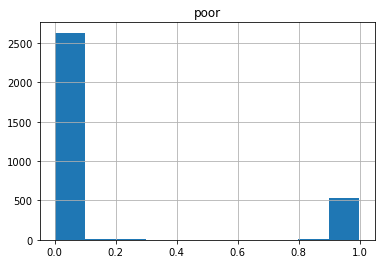

In [42]:
_ = sub_C.hist('poor')
plt.show()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++

# Expected log loss

In [43]:
total = len(test_A) + len(test_B) + len(test_C)
expected_log_loss = (np.mean(lgbm_A) * len(test_A) + np.mean(lgbm_B) * len(lgbm_B) + np.mean(lgbm_C) * len(test_C)) / total

print("Expected log loss : {}".format(expected_log_loss))

Expected log loss : 0.13232501122133222


# Final Submission

In [44]:
prob_sub = pd.concat((sub_A, sub_B, sub_C), 0).reset_index()

prob_sub.drop('index', 1, inplace = True)

print(sub.shape, prob_sub.shape)

prob_sub.id = prob_sub.id.astype('int')

pd.merge(sub, prob_sub, on = 'id').set_index('id').to_csv('C:/Users/user/Desktop/Pover-T Tests Predicting Poverty/sub_lgbm.csv')

(8832, 2) (8832, 2)
